IMPORT DATASET


In [3]:
import pandas as pd
import numpy as np

#load dataset
df = pd.read_excel("news_dataset.xlsx")

#show basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())

#preview some rows
df.head(10)

Dataset shape: (300, 4)

Columns: ['id', 'text', 'label', 'source']

Missing values per column:
 id        0
text      0
label     0
source    0
dtype: int64


,id,text,label,source
0,1,Produk Alkohol Tersenarai dalam Barangan Bantu...,fake,sebenarnya.my
1,2,KTM Berhad - National Day Gift Through the que...,fake,sebenarnya.my
2,3,Malaysian state threatens to jail Muslim men w...,real,The Guardian
3,4,Suicide will be officially decriminalised star...,real,Reddit
4,5,"Law repealed, suicide attempts no longer crim...",real,The Sun
5,6,Kerajaan bakal haramkan sepenuhnya penjualan r...,real,Buletin TV3
6,7,Bantuan Penghargaan SARA Sebanyak RM100 Akan D...,real,sebenarnya.my
7,8,Philippines vs. Malaysia: Tensions Rise Over S...,fake,sebenarnya.my
8,9,Malaysia jumps eight spots in global talent ra...,real,MalayMail
9,10,Penunggang Motosikal Boleh Merasai Pengalaman ...,fake,sebenarnya.my



DATA CLEANING & TEXT PREPROCESSING


In [4]:
import re
import string

#cleaning functions
def clean_text(text):
    #lowercase
    text = text.lower()

    #remove URLs and links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #remove (@username) and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    #remove numbers
    text = re.sub(r'\d+', '', text)

    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    #remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    #optionally remove filler words common in Bahasa Rojak
    filler_words = ['lah', 'la',  'kan', 'dehh', 'deh', 'ye', 'tu']
    for w in filler_words:
        text = re.sub(r'\b' + w + r'\b', '', text)

    return text

In [5]:
#dictionary for short forms
shortform_dict = {
    #malay
    "yg": "yang", "x": "tak", "tk": "tak", "tq": "terima kasih", "shj": "sahaja", "td": "tadi", 
    "dgn": "dengan", "sbb": "sebab", "utk": "untuk", "kpd": "kepada", "der": "ada", "dgr": "dengar", 
    "dlm": "dalam", "pd": "pada", "blh": "boleh", "dh": "dah", "jgk": "juga", "bg": "bagi", "sdh": "sudah", 
    "tp": "tapi", "sy": "saya", "dr": "dari", "akn": "akan", "mkn": "makan", "mmg": "memang",
    "nk": "nak", "skrg": "sekarang", "bru": "baru", "ttp": "tetapi", "lg": "lagi", "dlm": "dalam", 
    "klau": "kalau", "kalu": "kalau", "ade": "ada", "xde": "tiada", "org": "orang", "tgk": "tengok",
    
    #english
    "yrs": "years", "pls": "please", "n": "and", "otw": "on the way", "u": "you", "ur": "your", "r": "are",
    "btw": "by the way", "idk": "i do not know", "omg": "oh my god", "abt": "about",
    "bc": "because", "bcoz": "because", "bcz": "because", "coz": "because", "thx": "thanks",
    "wanna": "want to", "gonna": "going to", "gotta": "got to", "b4": "before"
}

def normalize_shortforms(text):
    words = text.split()
    normalized_words = [shortform_dict.get(w.lower(), w) for w in words]
    return " ".join(normalized_words)

#apply
df['normalized_text'] = df['text'].apply(normalize_shortforms)
df['clean_text'] = df['normalized_text'].apply(clean_text)

#preview results
df[['text', 'normalized_text', 'clean_text']].head(10)

,text,normalized_text,clean_text
0,Produk Alkohol Tersenarai dalam Barangan Bantu...,Produk Alkohol Tersenarai dalam Barangan Bantu...,produk alkohol tersenarai dalam barangan bantu...
1,KTM Berhad - National Day Gift Through the que...,KTM Berhad - National Day Gift Through the que...,ktm berhad national day gift through the quest...
2,Malaysian state threatens to jail Muslim men w...,Malaysian state threatens to jail Muslim men w...,malaysian state threatens to jail muslim men w...
3,Suicide will be officially decriminalised star...,Suicide will be officially decriminalised star...,suicide will be officially decriminalised star...
4,"Law repealed, suicide attempts no longer crim...","Law repealed, suicide attempts no longer criminal",law repealed suicide attempts no longer criminal
5,Kerajaan bakal haramkan sepenuhnya penjualan r...,Kerajaan bakal haramkan sepenuhnya penjualan r...,kerajaan bakal haramkan sepenuhnya penjualan r...
6,Bantuan Penghargaan SARA Sebanyak RM100 Akan D...,Bantuan Penghargaan SARA Sebanyak RM100 Akan D...,bantuan penghargaan sara sebanyak rm akan disa...
7,Philippines vs. Malaysia: Tensions Rise Over S...,Philippines vs. Malaysia: Tensions Rise Over S...,philippines vs malaysia tensions rise over sab...
8,Malaysia jumps eight spots in global talent ra...,Malaysia jumps eight spots in global talent ra...,malaysia jumps eight spots in global talent ra...
9,Penunggang Motosikal Boleh Merasai Pengalaman ...,Penunggang Motosikal Boleh Merasai Pengalaman ...,penunggang motosikal boleh merasai pengalaman ...


In [4]:
#save cleaned dataset
df.to_excel("news_dataset_cleaned.xlsx", index=False)


FEATURE EXTRACTION FOR TRADITIONAL MODELS (LR & SVM)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, csr_matrix

df = pd.read_excel("news_dataset_sentiment.xlsx")
df.head()

,id,text,label,source,normalized_text,clean_text,sentiment
0,1,Produk Alkohol Tersenarai dalam Barangan Bantu...,fake,sebenarnya.my,Produk Alkohol Tersenarai dalam Barangan Bantu...,produk alkohol tersenarai dalam barangan bantu...,neutral
1,2,KTM Berhad - National Day Gift Through the que...,fake,sebenarnya.my,KTM Berhad - National Day Gift Through the que...,ktm berhad national day gift through the quest...,neutral
2,3,Malaysian state threatens to jail Muslim men w...,real,The Guardian,Malaysian state threatens to jail Muslim men w...,malaysian state threatens to jail muslim men w...,negative
3,4,Suicide will be officially decriminalised star...,real,Reddit,Suicide will be officially decriminalised star...,suicide will be officially decriminalised star...,neutral
4,5,"Law repealed, suicide attempts no longer crim...",real,The Sun,"Law repealed, suicide attempts no longer criminal",law repealed suicide attempts no longer criminal,negative


In [2]:
#split the data to keep features aligned
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Train / Test sizes:", len(train_df), "/", len(test_df))

Train / Test sizes: 240 / 60


In [3]:
#TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf  = vectorizer.transform(test_df['clean_text'])

In [4]:
#One-hot encode sentiment for train and test
sent_cols = ['sent_negative', 'sent_neutral', 'sent_positive']
train_sent_ohe = pd.get_dummies(train_df['sentiment'], prefix='sent').reindex(columns=sent_cols, fill_value=0)
test_sent_ohe  = pd.get_dummies(test_df['sentiment'],  prefix='sent').reindex(columns=sent_cols, fill_value=0)

In [5]:
#convert to sparse and stack with TF-IDF
X_train_sent = csr_matrix(train_sent_ohe.values)
X_test_sent  = csr_matrix(test_sent_ohe.values)

In [6]:
X_train_comb = hstack([X_train_tfidf, X_train_sent], format='csr')
X_test_comb  = hstack([X_test_tfidf,  X_test_sent],  format='csr')

In [7]:
#labels
y_train = train_df['label'].values
y_test  = test_df['label'].values

In [8]:
print("Shapes -> TF-IDF train:", X_train_tfidf.shape, "sent train:", X_train_sent.shape, "combined:", X_train_comb.shape)

Shapes -> TF-IDF train: (240, 4527) sent train: (240, 3) combined: (240, 4530)


In [9]:
#train logistic regression
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_comb, y_train)
y_pred_lr = lr_model.predict(X_test_comb)

In [10]:
#train SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_comb, y_train)
y_pred_svm = svm_model.predict(X_test_comb)

In [11]:
#evaluate and print
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression
Accuracy: 0.6833333333333333
              precision    recall  f1-score   support

        fake     0.6774    0.7000    0.6885        30
        real     0.6897    0.6667    0.6780        30

    accuracy                         0.6833        60
   macro avg     0.6835    0.6833    0.6832        60
weighted avg     0.6835    0.6833    0.6832        60



In [12]:
print("\nSupport Vector Machine")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=4))


Support Vector Machine
Accuracy: 0.7166666666666667
              precision    recall  f1-score   support

        fake     0.6970    0.7667    0.7302        30
        real     0.7407    0.6667    0.7018        30

    accuracy                         0.7167        60
   macro avg     0.7189    0.7167    0.7160        60
weighted avg     0.7189    0.7167    0.7160        60



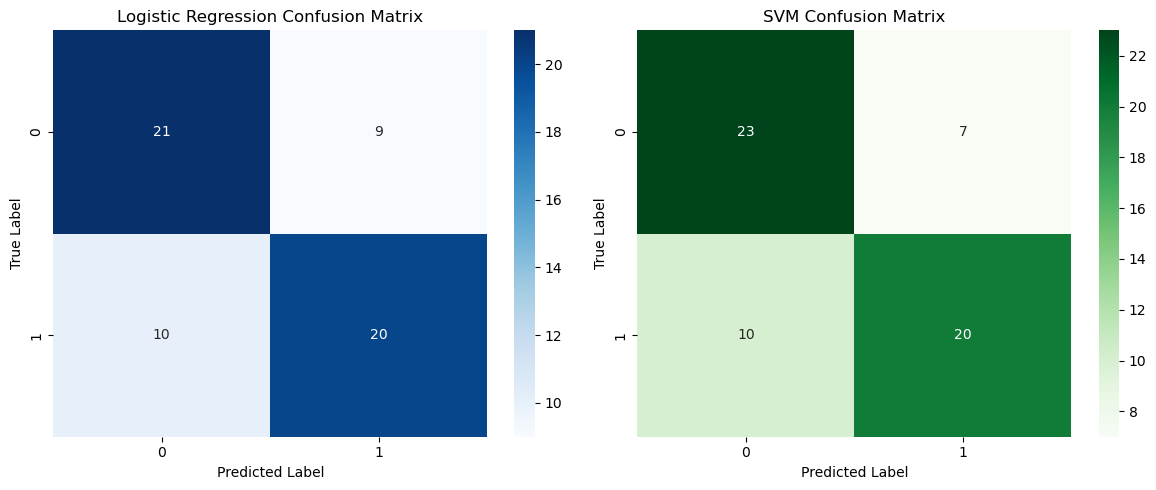

In [13]:
#confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("SVM Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


TRANSFORMER MODELS (BERT & mBERT)


In [27]:
#install libraries for transformer models
!pip install transformers torch --quiet

from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [18]:
df = pd.read_excel("news_dataset_sentiment.xlsx")

X = df['clean_text']
y = df['label']

In [19]:
#encode labels ('fake', 'real') to 0,1
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'fake': 0, 'real': 1}


In [20]:
#encode sentiment as one-hot
sentiment_map = {"negative": [1,0,0], "neutral": [0,1,0], "positive": [0,0,1]}
sentiment_features = torch.tensor([sentiment_map[s] for s in df['sentiment']], dtype=torch.float)

In [21]:
#split train/test
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels, train_sent, test_sent = train_test_split(
    X.tolist(), 
    y_encoded.tolist(), 
    sentiment_features, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

In [22]:
#custom dataset class (text + sentiment)
class NewsDataset(Dataset):
    def __init__(self, texts, labels, sentiments, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        sentiment = self.sentiments[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'sentiment': sentiment  # add sentiment feature
        }

In [23]:
#load BERT tokenizer
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

train_dataset_bert = NewsDataset(train_texts, train_labels, train_sent, tokenizer_bert)
test_dataset_bert = NewsDataset(test_texts, test_labels, test_sent, tokenizer_bert)

In [24]:
#define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [19]:
!pip install --upgrade accelerate==0.30.0 transformers==4.40.2 huggingface-hub==0.22.2 --quiet

In [28]:
#load pretrained BERT model
model_bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels=len(set(train_labels))
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
#training arguments
training_args = TrainingArguments(
    output_dir="./results_bert",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_strategy="epoch"
)

In [30]:
#initialize Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics
)

In [31]:
#train & evaluate
trainer_bert.train()
bert_results = trainer_bert.evaluate()
print("BERT Results:", bert_results)

C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.701600,0.695321,0.500000,0.250000,0.500000,0.333333
2,0.706200,0.690662,0.666667,0.667411,0.666667,0.666296


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Results: {'eval_loss': 0.6906620860099792, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.6674107142857143, 'eval_recall': 0.6666666666666666, 'eval_f1': 0.6662958843159065, 'eval_runtime': 11.403, 'eval_samples_per_second': 5.262, 'eval_steps_per_second': 0.702, 'epoch': 2.0}


In [32]:
#repeat for mBERT
tokenizer_mbert = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_dataset_mbert = NewsDataset(train_texts, train_labels, train_sent, tokenizer_mbert)
test_dataset_mbert = NewsDataset(test_texts, test_labels, test_sent, tokenizer_mbert)

model_mbert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(set(train_labels))
)

training_args_mbert = TrainingArguments(
    output_dir="./results_mbert",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs_mbert",
    logging_strategy="epoch"
)

trainer_mbert = Trainer(
    model=model_mbert,
    args=training_args_mbert,
    train_dataset=train_dataset_mbert,
    eval_dataset=test_dataset_mbert,
    compute_metrics=compute_metrics
)

trainer_mbert.train()
mbert_results = trainer_mbert.evaluate()
print("mBERT Results:", mbert_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.728600,0.682052,0.683333,0.701465,0.683333,0.676044
2,0.603500,0.623165,0.700000,0.708333,0.700000,0.696970


C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\user\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


mBERT Results: {'eval_loss': 0.6231653690338135, 'eval_accuracy': 0.7, 'eval_precision': 0.7083333333333334, 'eval_recall': 0.7, 'eval_f1': 0.6969696969696969, 'eval_runtime': 11.3949, 'eval_samples_per_second': 5.265, 'eval_steps_per_second': 0.702, 'epoch': 2.0}
